In [23]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
# Create 4 simple recognizable 10x10 patterns (letters/numbers/shapes)
img_dim = 10
patterns = []

# Pattern 1: X shape
X = np.zeros((img_dim,img_dim))
for i in range(img_dim):
    X[i,i] = 1
    X[i,9-i] = 1
patterns.append(X)

# Pattern 2: O shape (circle-like border)
O = np.zeros((10,10))
O[0,:] = 1
O[-1,:] = 1
O[:,0] = 1
O[:,-1] = 1
patterns.append(O)

# Pattern 3: Checkerboard
checker = np.fromfunction(lambda i, j: ((i + j) % 2), (img_dim,img_dim))
patterns.append(checker)

# Pattern 4: L shape
L = np.zeros((10,10))
L[:-2,1] = 1
L[-2,1:] = 1
patterns.append(L)

patterns = np.array(patterns)

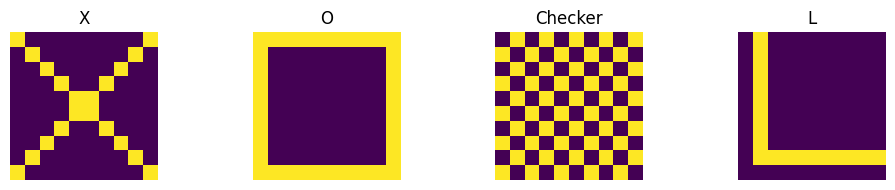

In [25]:
# Display patterns
fig, axes = plt.subplots(1, 4, figsize=(10,2))
axes = axes.flatten()
titles = ["X", "O", "Checker", "L"]

for i in range(4):
    axes[i].imshow(patterns[i], interpolation='nearest')
    axes[i].set_title(titles[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [26]:
class Neuron:
    def __init__(self, index, is_visible=True, bias=0.0):
        self.index = index
        self.is_visible = is_visible
        self.bias = bias
        self.state = 0.0
        
    def activate(self, x):
        return 1 / (1 + np.exp(-x))

    def sample_state(self, input_sum):
        p = self.activate(input_sum)
        self.state = 1.0 if np.random.rand() < p else 0.0
        return self.state

In [27]:
class BoltzmannMachine:
    def __init__(self, n_visible, n_hidden):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.n_units = n_visible + n_hidden
        
        # Symmetric weight matrix
        self.W = np.random.normal(0, 0.01, (self.n_units, self.n_units))
        np.fill_diagonal(self.W, 0.0)
        
        # Neuron objects
        self.neurons = []
        for i in range(n_visible):
            self.neurons.append(Neuron(i, is_visible=True))
        for i in range(n_hidden):
            self.neurons.append(Neuron(n_visible + i, is_visible=False))
            
        # Bias vector
        self.bias = np.zeros(self.n_units)

    def _unit_input(self, i):
        '''This function calculates input to neuron i'''
        states = np.array([n.state for n in self.neurons])
        return np.dot(self.W[i], states) + self.bias[i]

    def sample_unit(self, i):
        input_sum = self._unit_input(i)
        return self.neurons[i].sample_state(input_sum)

    def gibbs_step(self):
        '''Update all units in random order'''
        order = np.random.permutation(self.n_units)
        for i in order:
            self.sample_unit(i)
            
    def run_clamped_phase(self, data, steps=50):
        '''
        Clamp visible units to data and sample hidden units
        
        data: vector of length n_visible (0/1)
        '''
        
        # Clamp visible units
        for i in range(self.n_visible):
            self.neurons[i].state = data[i]

        # Sample hidden units for some steps
        for _ in range(steps):
            for j in range(self.n_visible, self.n_units):
                self.sample_unit(j)

        # Compute correlations <s_i s_j>_data
        s = np.array([n.state for n in self.neurons])
        return np.outer(s, s)

    def run_free_phase(self, steps=200):
        '''
        No clamped units (Samples across units freely)
        '''
        # run full Gibbs sampling
        for _ in range(steps):
            self.gibbs_step()

        s = np.array([n.state for n in self.neurons])
        return np.outer(s, s)

    def train_step(self, data, lr=0.01):
        pos_corr = self.run_clamped_phase(data)
        neg_corr = self.run_free_phase()

        self.W += lr * (pos_corr - neg_corr)

        # keep symmetry
        self.W = (self.W + self.W.T) / 2
        np.fill_diagonal(self.W, 0.0)


In [28]:
bm = BoltzmannMachine(n_visible=100, n_hidden=20)

n_epochs = 50
learning_rate = 0.01
flat_patterns = [p.flatten() for p in patterns]

for epoch in range(n_epochs):
    epoch_loss = 0

    for data in flat_patterns:
        bm.train_step(data, lr=learning_rate)

    print(f"Epoch {epoch+1}/{n_epochs} complete.")


Epoch 1/50 complete.
Epoch 2/50 complete.
Epoch 3/50 complete.
Epoch 4/50 complete.
Epoch 5/50 complete.
Epoch 6/50 complete.
Epoch 7/50 complete.
Epoch 8/50 complete.
Epoch 9/50 complete.
Epoch 10/50 complete.
Epoch 11/50 complete.
Epoch 12/50 complete.
Epoch 13/50 complete.
Epoch 14/50 complete.
Epoch 15/50 complete.
Epoch 16/50 complete.
Epoch 17/50 complete.
Epoch 18/50 complete.
Epoch 19/50 complete.
Epoch 20/50 complete.
Epoch 21/50 complete.
Epoch 22/50 complete.
Epoch 23/50 complete.
Epoch 24/50 complete.
Epoch 25/50 complete.
Epoch 26/50 complete.
Epoch 27/50 complete.
Epoch 28/50 complete.
Epoch 29/50 complete.
Epoch 30/50 complete.
Epoch 31/50 complete.
Epoch 32/50 complete.
Epoch 33/50 complete.
Epoch 34/50 complete.
Epoch 35/50 complete.
Epoch 36/50 complete.
Epoch 37/50 complete.
Epoch 38/50 complete.
Epoch 39/50 complete.
Epoch 40/50 complete.
Epoch 41/50 complete.
Epoch 42/50 complete.
Epoch 43/50 complete.
Epoch 44/50 complete.
Epoch 45/50 complete.
Epoch 46/50 complet

In [29]:
def sample_free(bm, steps=500):
    # random initial states
    for n in bm.neurons:
        n.state = np.random.rand() < 0.5

    # Gibbs sampling
    for _ in range(steps):
        bm.gibbs_step()

    # return visible sample
    vis = np.array([n.state for n in bm.neurons[:bm.n_visible]])
    return vis

In [30]:
sample = sample_free(bm)
sample_img = sample.reshape(10,10)

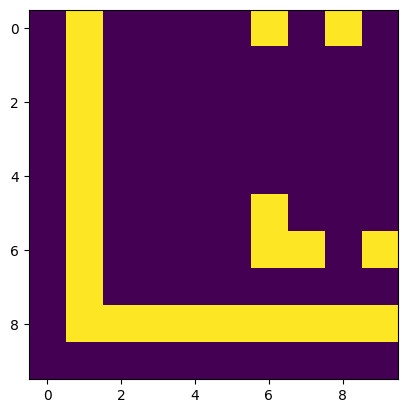

In [31]:
plt.imshow(sample_img)